<p style="background-color:White;">We know that before every IPL cricket season,an auction of cricket players is held and the players are recruited through an auction by the participating teams on the basis of their performance. In this project an attempt has been made to categorise the players according to their batting performance, so that the team owners can determine the actual value of a batsman before an auction.It is to be mentioned that there are many other aspects that are considered and batting performance is one of them. 
    We have a detailed data on IPL matches from 2008 to 2020. We attempt to simplify the data and cluster the players in different groups basis their previous IPL performance</p>



For our analysis, first we import the requisite libraries.

<h1 style="text-align:center;font-size:100%;;">The Libraries</h1>

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams
rcParams['figure.figsize'] = 9,7


<h1 style="text-align:center;font-size:100%;;">Glimpse of the data</h1>

Let us  have a birds eye view of the data structure.

In [28]:
df = pd.read_csv("./input/deliveries.csv")
print("Total number of rows is",len(df))
print(df.info())
df.head(2)

Total number of rows is 150460
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150460 entries, 0 to 150459
Data columns (total 21 columns):
match_id            150460 non-null int64
inning              150460 non-null int64
batting_team        150460 non-null object
bowling_team        150460 non-null object
over                150460 non-null int64
ball                150460 non-null int64
batsman             150460 non-null object
non_striker         150460 non-null object
bowler              150460 non-null object
is_super_over       150460 non-null int64
wide_runs           150460 non-null int64
bye_runs            150460 non-null int64
legbye_runs         150460 non-null int64
noball_runs         150460 non-null int64
penalty_runs        150460 non-null int64
batsman_runs        150460 non-null int64
extra_runs          150460 non-null int64
total_runs          150460 non-null int64
player_dismissed    7438 non-null object
dismissal_kind      7438 non-null object
fielder        

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,...,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN


Given is a ball by ball data on all IPL matches from 2008-2020.There are 150460 rows which represent each ball bowled during this event and contain all similar information regarding run scored and  3 items describing the dismissal kind, if the batsman got dismissed in that ball (player-dismissed, dismissal-kind,fielder).There are 21 columns describing the fate of the ball bowled.It appears there are no absurd entries and the data do not need any data cleaning operation. For the sake of analysis, we substitute all missing values or blanks by zero.

In [29]:
df = df.fillna(0)

In order to reach our ultimate aim of clustering the data, first we have to summarize the data in a form conducive for clustering operation. In other words, we require to find few characteristics which might best describe the quality of the batsman and help to cluster/ form groups with similar batsman :

First, we summarize the raw data and find out the 

A) the Total Run scored by each batsman - This is obtained by aggregating the run scored by each batsman at each ball over all the innings played throughout the IPL seasons from 2008-20.

The following code calculates this.


In [30]:
batsman_total_run = pd.pivot_table(df, index=["batsman"], values=["batsman_runs"], aggfunc=np.sum)
batsman_total_run.head(3)

,batsman_runs
batsman,
A Ashish Reddy,280
A Chandila,4
A Chopra,53


Now that we have summarized the data with the number of batsman who have ever batted in any IPL tournament during 2008-20,we are interested in knowing how many unique batsman are present in the data

In [31]:
len(batsman_total_run.index)

461

B) The Dismissals,
  we calculate the number of times each batsman got out
 
First let's have a look at the kind of dismissals the batsman  have, 

In [32]:
df["dismissal_kind"].value_counts()

0                        143022
caught                     4373
bowled                     1382
run out                     755
lbw                         455
stumped                     243
caught and bowled           211
retired hurt                  9
hit wicket                    9
obstructing the field         1
Name: dismissal_kind, dtype: int64

We know "Retired Hurt" cannot be considered as a dismissal though the batsman leaves the field, so while counting the number of times each batsman got out, let us not count ' retired hurt' as a dismissal.
Let us create a column, dismissal_yn which will be 1 if the Batsman ( ie the striker) got out, else zero.
Then we can sum the column for each batsman to get the number of times he got out

In [33]:
df.loc[df["dismissal_kind"] == 'retired hurt', 'dismissal_yn'] = 0

Also two forms of dismissal cought our attention - Run out and Obstructing the field.

The Striker may not get out in 'run out' and 'obstructing the field'types,as by Cricket rules, even the non-striker may get out by these two forms of dismissal.

lets have a look at the corresponding data

In [34]:
df[df["dismissal_kind"] == 'obstructing the field']

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,...,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder,dismissal_yn
105613,445,2,Kolkata Knight Riders,Pune Warriors,18,5,YK Pathan,DB Das,WD Parnell,0,...,0,0,0,0,0,0,YK Pathan,obstructing the field,0,NaN


In [35]:
df[df["dismissal_kind"] == 'run out'].head(3)

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,...,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder,dismissal_yn
199,1,2,Royal Challengers Bangalore,Sunrisers Hyderabad,12,4,KM Jadhav,TM Head,MC Henriques,0,...,0,0,0,1,0,1,KM Jadhav,run out,BCJ Cutting,NaN
247,1,2,Royal Challengers Bangalore,Sunrisers Hyderabad,20,4,A Choudhary,YS Chahal,BCJ Cutting,0,...,0,0,0,0,0,0,YS Chahal,run out,CJ Jordan (sub),NaN
371,2,1,Mumbai Indians,Rising Pune Supergiant,20,6,HH Pandya,TG Southee,AB Dinda,0,...,0,0,0,0,1,1,TG Southee,run out,MS Dhoni,NaN


So, instead of aggregating the number of dismissals directly from the data, let us make an indicator variable which will be 1, if 'batsman name' = 'Player Dismissed'name.That way, we will ensure that our count for number of dismissals for each batsman are not wrongly estimated.

In [36]:
df.loc[df['batsman'] == df['player_dismissed'], 'dismissal_yn'] = 1
df.loc[df['batsman'] != df['player_dismissed'], 'dismissal_yn'] = 0


Next we sum all dismissal_yn for each batsman,so that we may form a column containing the number of times a batsman got out

In [37]:
batsman_total_out = pd.pivot_table(df, index=["batsman"], values=["dismissal_yn"], aggfunc=np.sum)
batsman_total_out.head(3)

,dismissal_yn
batsman,
A Ashish Reddy,15.0
A Chandila,0.0
A Chopra,5.0


Next we calculate for each batsman
 The Total Balls faced - This is obtained by aggregating the balls faced by each batsman over all the innings played throughout the IPL seasons from 2008-20.
 The following code calculates this.


In [38]:
batsman_total_balls_faced = pd.pivot_table(df, index=["batsman"], values=["ball"], aggfunc = np.count_nonzero)
batsman_total_balls_faced.head(3)


,ball
batsman,
A Ashish Reddy,196
A Chandila,7
A Chopra,75


Let us keep the batsman names as columns (not as index) for all the three dataframe,so that the data can later be used for merging along the batsman names.

So now we have three dataframes -- total runs scored by batsman, total number of dismissals and total balls faced by each batsman.
The next code merges the three dataframes into one

In [39]:
batsman_total_run = batsman_total_run.reset_index()
batsman_total_out = batsman_total_out.reset_index()
batsman_total_balls_faced = batsman_total_balls_faced.reset_index()

In [40]:
m1 = pd.merge(batsman_total_run, batsman_total_out , on = 'batsman')
summary_data = pd.merge(m1, batsman_total_balls_faced, on = 'batsman')


Now we calculate some of the derived indicators widely used for measuring batting performance.

1) Strike Rate - Batting strike rate (s/r) is defined for a batsman as the average number of runs scored per 100 balls faced.

The higher the strike rate, the more effective a batsman is at scoring quickly.

2) Batting Average - It is the ratio of a player's number of runs scored to the number of times they have been out.

It is also considered as a good measuring tool for a batsman.

In [41]:
summary_data['strike_rate'] = (summary_data['batsman_runs']/summary_data['ball'])*100
summary_data['batting_average'] = summary_data['batsman_runs']/summary_data['dismissal_yn']
summary_data.head(5)

,batsman,batsman_runs,dismissal_yn,ball,strike_rate,batting_average
0,A Ashish Reddy,280,15.0,196,142.857143,18.666667
1,A Chandila,4,0.0,7,57.142857,inf
2,A Chopra,53,5.0,75,70.666667,10.600000
3,A Choudhary,25,1.0,20,125.000000,25.000000
4,A Flintoff,62,2.0,57,108.771930,31.000000


Incase, the batsman is never out, the denominator becomes zero, in that situation we accept batting average = runs scored. So all div by zero cases are replaced by runs scored
There are some cases, where the batsman havn't scored any run and was never out, which has np.NaN values, we replace them by zero

In [42]:
summary_data['batting_average'] = summary_data['batting_average'].replace(np.inf, summary_data['batsman_runs'])
summary_data['batting_average'] = summary_data['batting_average'].replace(np.NaN, summary_data['batsman_runs'])
summary_data.to_csv("./output/summary_data.csv")

Finally we have prepared the summary data from the original data of around 1.5L rows.
This data can be used for any other future work as well.
For clustering, we consider, batsman total run, balls faced, strike rate and batting average for clustering the players in different groups.
The final summary data consists of 461 batsman and 5 statistics

Let us have the statistics of the summary data.

In [43]:
summary_data.describe()

,batsman_runs,dismissal_yn,ball,strike_rate,batting_average
count,461.000000,461.000000,461.00000,461.000000,461.000000
mean,398.978308,15.366594,326.37744,101.712258,16.721260
std,785.443358,24.306335,617.31306,36.449593,11.787458
min,0.000000,0.000000,1.00000,0.000000,0.000000
25%,15.000000,2.000000,18.00000,80.000000,7.666667
50%,73.000000,5.000000,71.00000,107.407407,15.000000
75%,342.000000,17.000000,285.00000,125.000000,25.081633
max,4548.000000,128.000000,3494.00000,233.333333,88.000000


From the summary data, we observe, the minimum score of batsman is zero , which implied many batsman have scored zero. Let us check how many batsman have scored ducks.

In [44]:
summary_data[summary_data['batsman_runs'] == 0]

,batsman,batsman_runs,dismissal_yn,ball,strike_rate,batting_average
51,Abdur Razzak,0,0.0,2,0.0,0.0
80,C Nanda,0,1.0,1,0.0,0.0
156,IC Pandey,0,1.0,2,0.0,0.0
212,L Ablish,0,0.0,2,0.0,0.0
223,M Ashwin,0,1.0,1,0.0,0.0
273,ND Doshi,0,1.0,13,0.0,0.0
329,RR Bhatkal,0,1.0,2,0.0,0.0
350,S Kaushik,0,1.0,1,0.0,0.0
351,S Ladda,0,1.0,10,0.0,0.0
409,Sunny Gupta,0,1.0,1,0.0,0.0


There are some cases, where the batsman havn't scored any run in any matches, we decide to not include them in our clustering of batsman, so as to have a frame of batsman having some minimum quality.

In [45]:
non_zero_df = (summary_data[summary_data['batsman_runs'] > 0])
non_zero_df = summary_data.drop(['dismissal_yn'], axis =1 )
X = non_zero_df[['batsman_runs','strike_rate', 'batting_average','ball']].values

First we scale the data using standardscaler, so that the algorithm is not affected by magnitude of values.

Given the distribution of the data, each value in each column will have the mean value subtracted, and then divided by the standard deviation of the respective column so that its distribution will have a mean value 0 and standard deviation of 1.

In [46]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

Now we draw a Dendogram to understand how many clusters are intrinsically present within the data.
The dendrogram illustrates how each cluster is composed by drawing a U-shaped link between a non-singleton cluster and its children.
Code for plotting Dendogram .

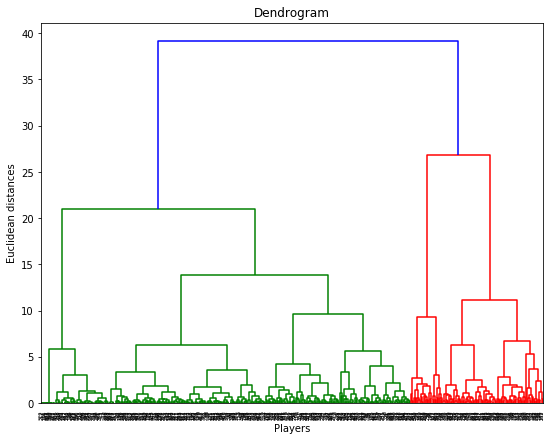

In [47]:
import scipy.cluster.hierarchy as sch
dendrogram = sch.dendrogram(sch.linkage(X_scaled, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Players')
plt.ylabel('Euclidean distances')
plt.show()


The key to interpreting a dendrogram is to focus on the height at which any two objects are joined together. Observations are allocated to clusters by drawing a horizontal line through the dendrogram. Observations that are joined together below the line are in clusters.
So it appears that there are 5 clusters if we imagine the horizontal line at about height of Euclidean Distance-11.

Now we employ the "Ward's method for clustering" on the data.T

In [48]:
from sklearn.cluster import AgglomerativeClustering

hc = AgglomerativeClustering(n_clusters = 5, affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(X_scaled)


The y_hc variable contains the cluster labels for each batsman in the scaled data. However for understanding purpose, we have to incorporate the same on our original non_zero_df which contains the summarized original data.
Let us incorporate this labelling on our inital non_zero_df

In [49]:
non_zero_df['cluster_number_ward']= y_hc

Let us check the the cluster means to get an idea about the clusters formed.

In [50]:
non_zero_df.groupby(['cluster_number_ward']).mean()

,batsman_runs,ball,strike_rate,batting_average
cluster_number_ward,,,,
0,735.750000,595.043478,129.284317,30.866442
1,157.563910,137.714286,122.742713,17.376848
2,2953.933333,2319.966667,127.294956,32.908893
3,5.580645,12.290323,36.577524,2.470123
4,43.888889,48.881944,87.387207,9.842034


Let us separate the clusters and have a look at each of the clusters separately through a CSV output.

In [51]:
cluster_0_ward = non_zero_df[non_zero_df['cluster_number_ward'] == 0]
cluster_1_ward = non_zero_df[non_zero_df['cluster_number_ward'] == 1]
cluster_2_ward = non_zero_df[non_zero_df['cluster_number_ward'] == 2]
cluster_3_ward = non_zero_df[non_zero_df['cluster_number_ward'] == 3]
cluster_4_ward = non_zero_df[non_zero_df['cluster_number_ward'] == 4]


In [52]:
cluster_0_ward.to_csv("./output/ward/cluster_0_ward.csv")
cluster_1_ward.to_csv("./output/ward/cluster_1_ward.csv")
cluster_2_ward.to_csv("./output/ward/cluster_2_ward.csv")
cluster_3_ward.to_csv("./output/ward/cluster_3_ward.csv")
cluster_4_ward.to_csv("./output/ward/cluster_4_ward.csv")
